
## What is Sentiment Analysis?
Sentiment Analysis is the process of ‘computationally’ determining whether a piece of writing is positive, negative or neutral. It’s also known as opinion mining, deriving the opinion or attitude of a speaker.

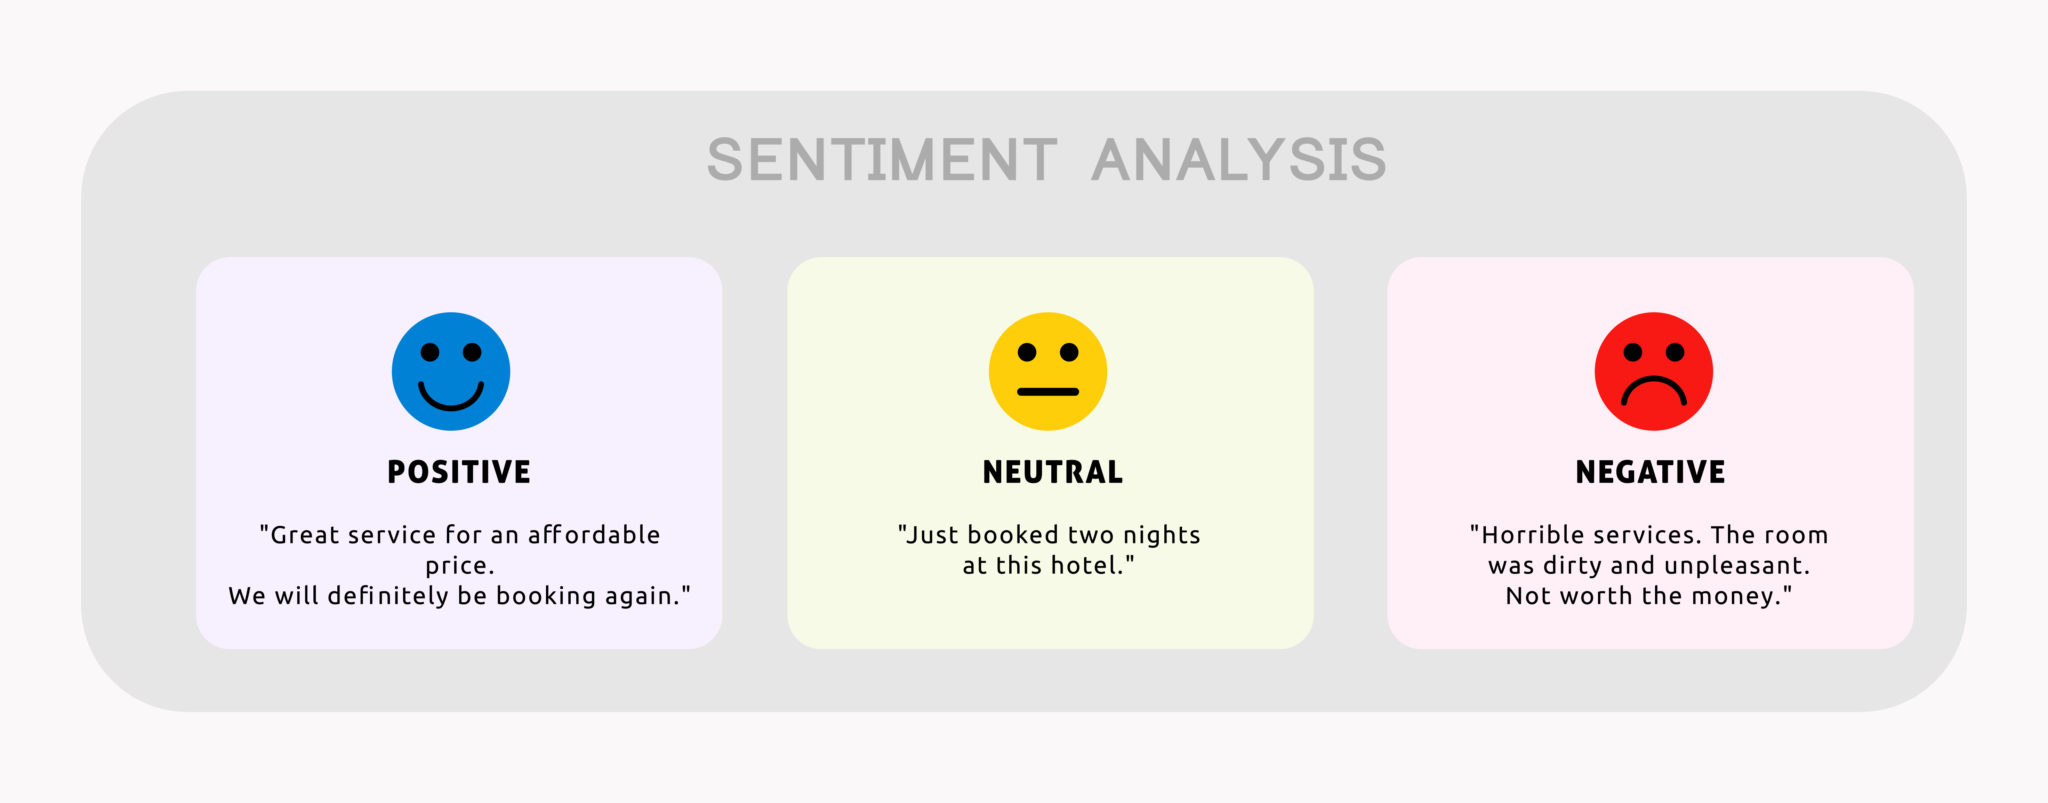

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pickle

In [3]:
# Load the dataset
df = pd.read_csv('twitter_sentiment.csv', header=None, index_col=[0])
df = df[[2,3]].reset_index(drop=True)
df.columns = ['sentiment', 'text']
df.head()

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [4]:
# Data Information
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  75682 non-null  object
 1   text       74996 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB
None
sentiment      0
text         686
dtype: int64


In [5]:
# Display the distribution of sentiments
print(df['sentiment'].value_counts())

sentiment
Negative      22808
Positive      21109
Neutral       18603
Irrelevant    13162
Name: count, dtype: int64


In [6]:
# Ensure the 'text' column is string type and handle NaN values
df['text'] = df['text'].astype(str)

# Feature extraction functions
def char_counts(text):
    return len(text) if text else 0

def word_counts(text):
    return len(text.split()) if text else 0

def avg_wordlength(text):
    words = text.split()
    return sum(len(word) for word in words) / len(words) if len(words) > 0 else 0

def stopwords_counts(text):
    stopwords = set(STOPWORDS)
    return len([word for word in text.split() if word in stopwords])

def hashtag_counts(text):
    return len([word for word in text.split() if word.startswith('#')])

def mentions_counts(text):
    return len([word for word in text.split() if word.startswith('@')])

def digits_counts(text):
    return len([char for char in text if char.isdigit()])

def uppercase_counts(text):
    return len([char for char in text if char.isupper()])

# Apply feature extraction
df['char_counts'] = df['text'].apply(char_counts)
df['word_counts'] = df['text'].apply(word_counts)
df['avg_wordlength'] = df['text'].apply(avg_wordlength)
df['stopwords_counts'] = df['text'].apply(stopwords_counts)
df['hashtag_counts'] = df['text'].apply(hashtag_counts)
df['mentions_counts'] = df['text'].apply(mentions_counts)
df['digits_counts'] = df['text'].apply(digits_counts)
df['uppercase_counts'] = df['text'].apply(uppercase_counts)


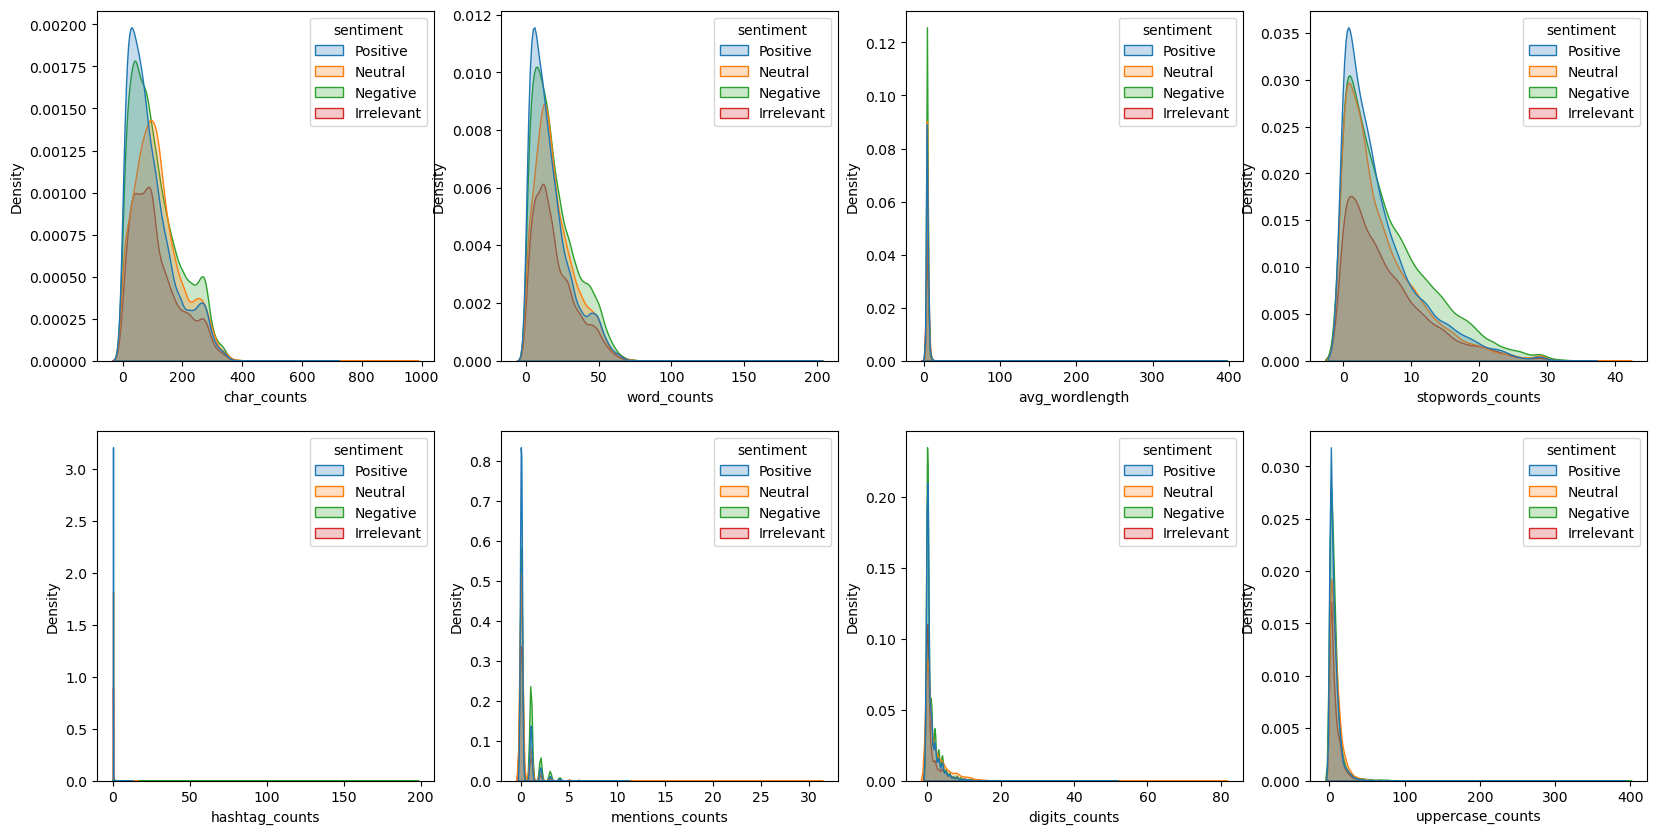

In [7]:
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# plot 2x4 grid histogram for each numerical feature
plt.figure(figsize=(20,10))

num_cols = df.select_dtypes(include='number').columns

for col in num_cols:
    plt.subplot(2,4, num_cols.get_loc(col)+1)

    # use sentiment as hue to see the distribution of each numerical feature
    # sns.distplot(df[col], label=col, color='red')
    # sns.histplot(x=col, hue='sentiment', data=df, color='green', bins=100, kde=True)
    sns.kdeplot(data=df, x=col, hue='sentiment', fill=True)



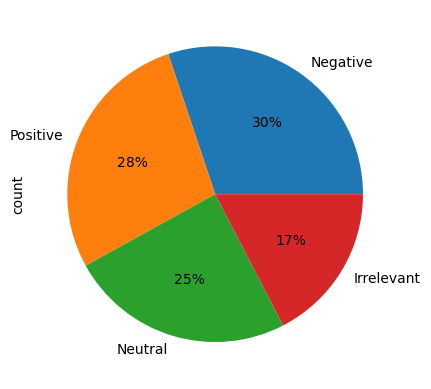

In [8]:
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%')

# word cloud
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

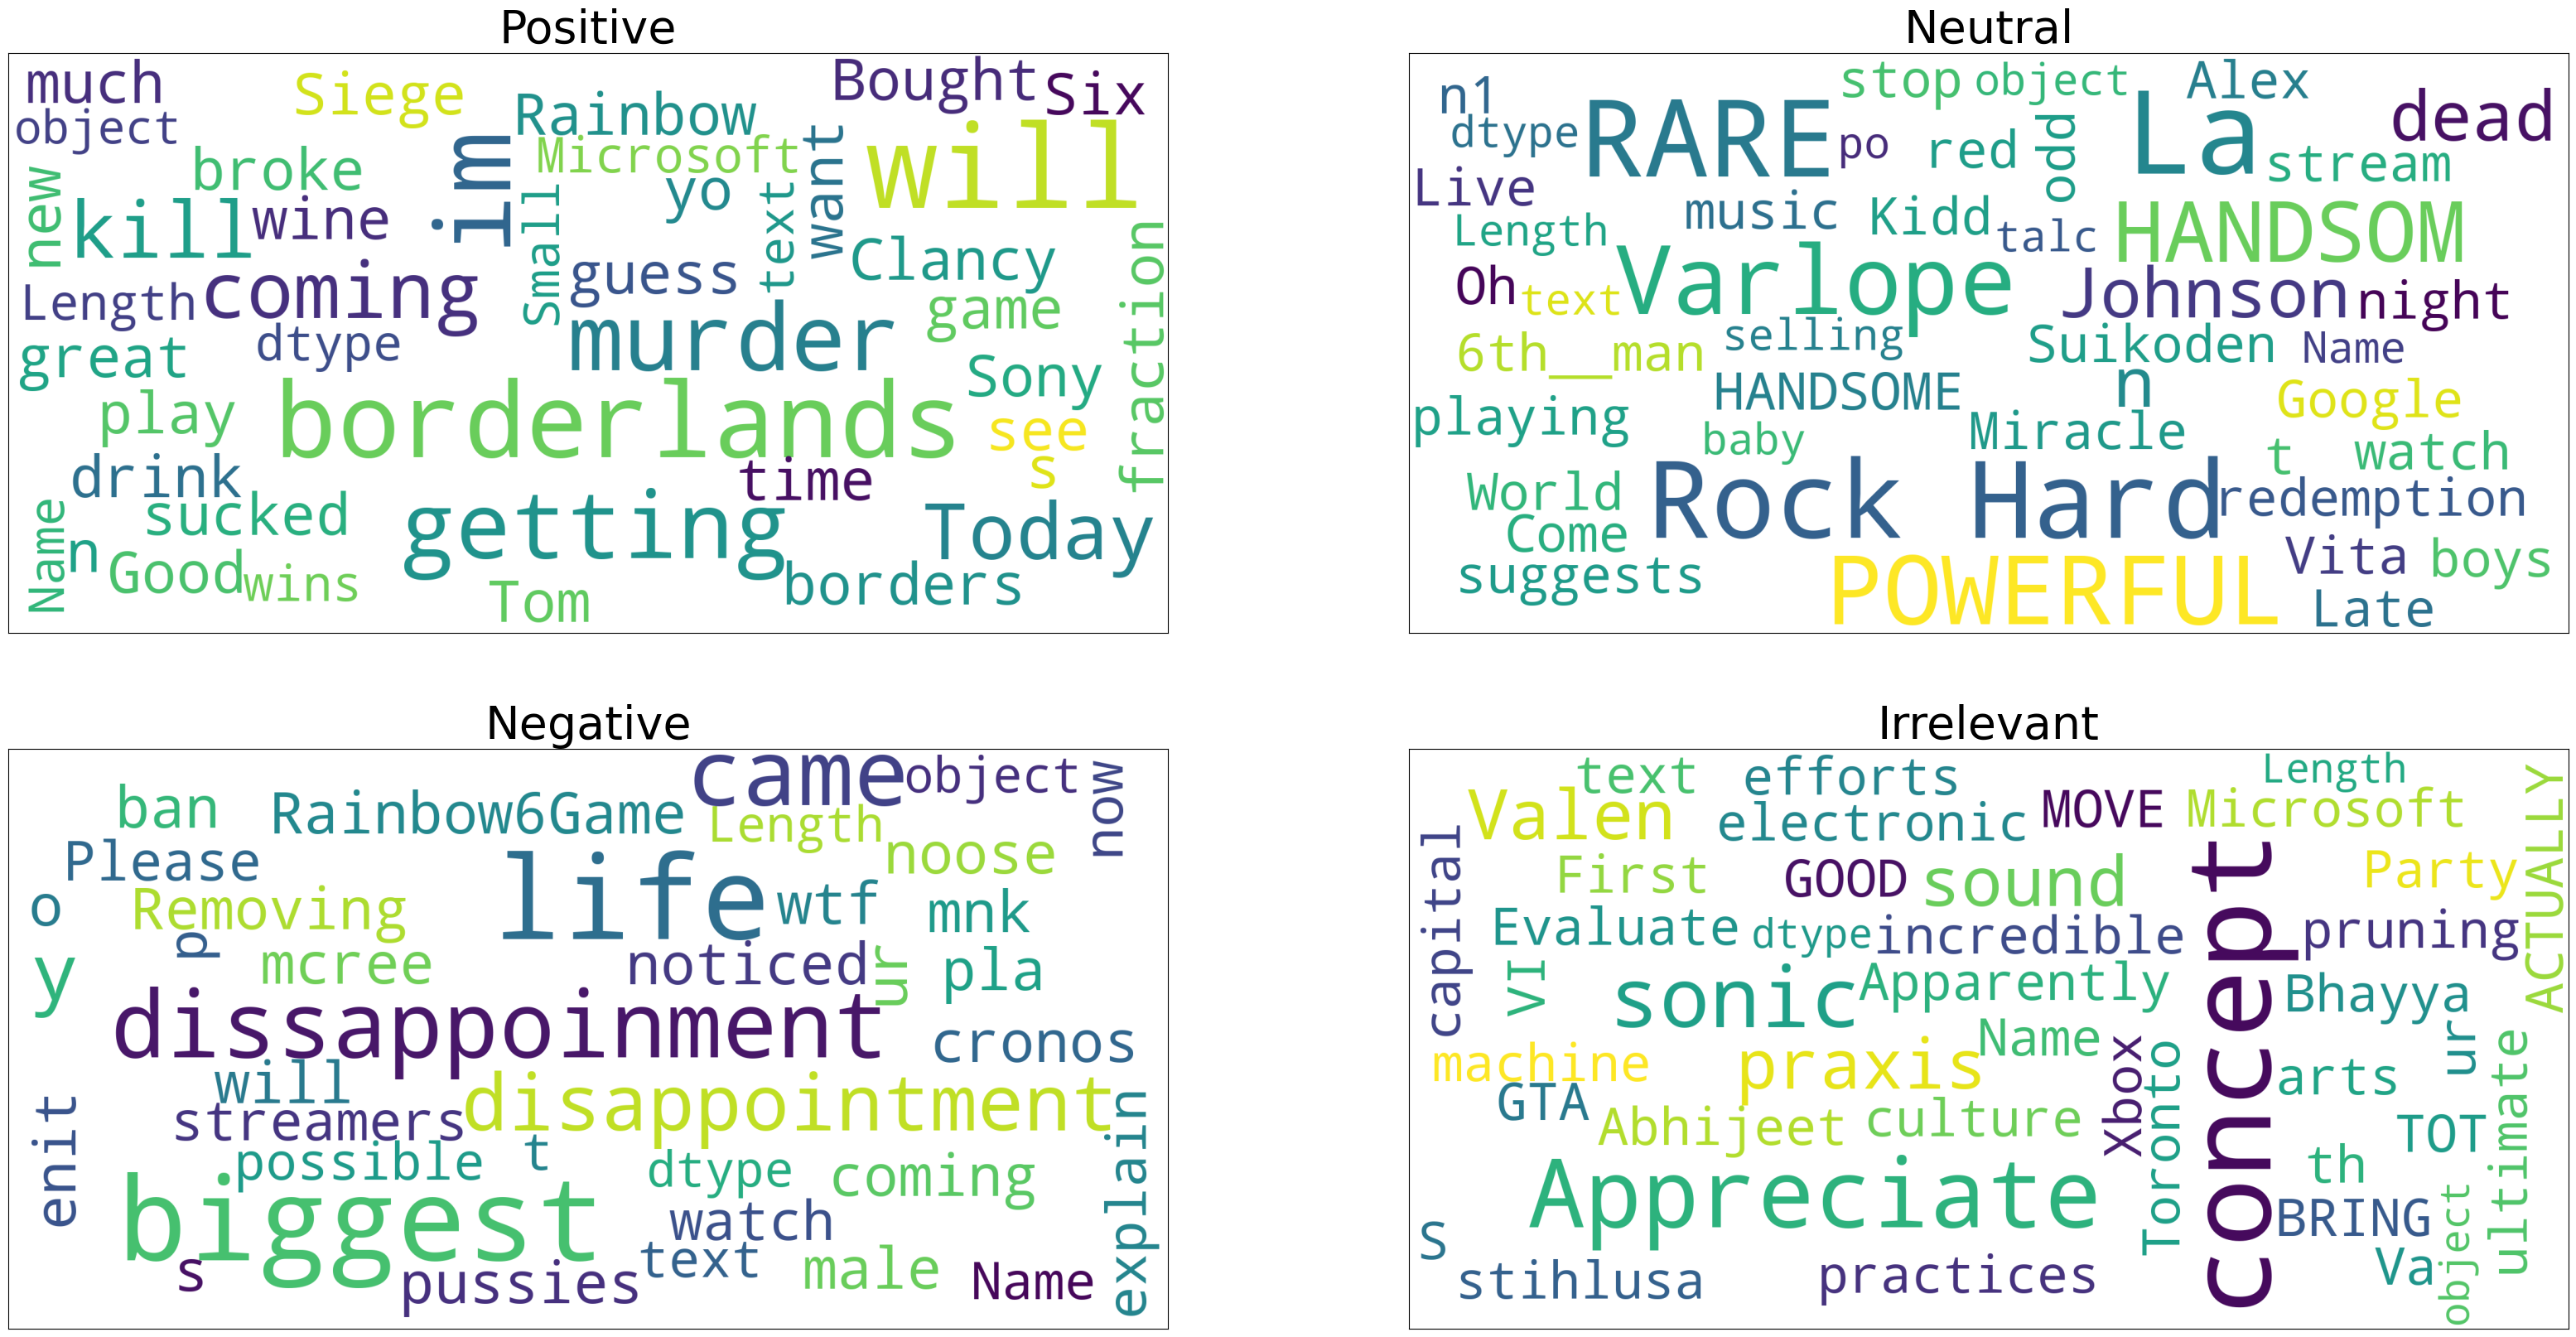

<Figure size 640x480 with 0 Axes>

In [9]:
# plot 2x2 grid word cloud for each sentiment
plt.figure(figsize=(40,20))

for index, col in enumerate(df['sentiment'].unique()):
    plt.subplot(2,2, index+1)
    # print(col)
    df1 = df[df['sentiment']==col]
    data = df1['text']
    wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=500, max_font_size=40, scale=5).generate(str(data))
    # fig = plt.figure(figsize=(15,15))
    # plt.axis('off')
    # disable ticks
    plt.xticks([])
    plt.yticks([])
    plt.imshow(wordcloud)
    plt.title(col, fontsize=40)
    
plt.show()
plt.tight_layout()


In [10]:
# Data Cleaning
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply(lambda x: x if 'http' not in x else '')
df['text'] = df['text'].apply(lambda x: ''.join(e for e in x if e.isalnum() or e.isspace()))
df['text'] = df['text'].apply(lambda x: ' '.join(word for word in x.split() if word not in STOPWORDS))


In [11]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)
print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")


Training data shape: (60545,), Testing data shape: (15137,)


In [12]:
# Convert STOPWORDS to a list before passing to TfidfVectorizer
clf = Pipeline([('tfidf', TfidfVectorizer(stop_words=list(STOPWORDS))), 
                ('clf', RandomForestClassifier(n_estimators=100, n_jobs=-1))])
clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['was', 'down', "i'll", "shan't",
                                             'the', 'have', 'http', "let's",
                                             "why's", 'with', "you'll", 'why',
                                             'from', "she'd", 'since', 'during',
                                             "we're", 'should', 'over', 'did',
                                             'yourself', 'doing', 'those',
                                             'ourselves', 'having', 'that',
                                             'your', "we'll", 'com', 'than', ...])),
                ('clf', RandomForestClassifier(n_jobs=-1))])

In [13]:
# Model Evaluation
predictions = clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.8873620928849838


In [14]:
# Save the Model
with open('twitter_sentiment.pkl', 'wb') as model_file, open('test_data.txt', 'w') as test_file:
    pickle.dump(clf, model_file)


In [15]:
# Display some sample predictions
print(X_test.tolist()[:20])


['noob pro motivational journey story every noob pubg players youtubep7norsoxqc via youtube youtubeindia', 'hated everything earned tumor youth achievement', 'havent played pubg week feels weird', 'cute panda dragon tress steal much resources nonthong messy cry trash poser hero dota2 icefrog', 'idea positive obviously superm', 'eamaddennfl give us yellow chiefs endzone thats featured years superbowl pretty soon please', 'black ops cold war s core way better pile shit modern warfare listen will m sit 100 hours punished happen good t rid cod sbmm m gonna buy s simple', 'great piece music futbal legend african win fifa world player year award george weah prez blakkrasta zylofon1021fm', 'blowing top byplaystationcom', 'forensic services dead going brought spoiler alert soon', 'every hell casino shut walmart home depot shut', 'nba2kmyteamunk', '', '', 'apt quote art ive seen one artists stuff weird lol started warcraft draenei hentai got really hyped cyberpunk 2077 lol', 'suddenly longer sw

In [16]:
X_test.tolist()[:20]

['noob pro motivational journey story every noob pubg players youtubep7norsoxqc via youtube youtubeindia',
 'hated everything earned tumor youth achievement',
 'havent played pubg week feels weird',
 'cute panda dragon tress steal much resources nonthong messy cry trash poser hero dota2 icefrog',
 'idea positive obviously superm',
 'eamaddennfl give us yellow chiefs endzone thats featured years superbowl pretty soon please',
 'black ops cold war s core way better pile shit modern warfare listen will m sit 100 hours punished happen good t rid cod sbmm m gonna buy s simple',
 'great piece music futbal legend african win fifa world player year award george weah prez blakkrasta zylofon1021fm',
 'blowing top byplaystationcom',
 'forensic services dead going brought spoiler alert soon',
 'every hell casino shut walmart home depot shut',
 'nba2kmyteamunk',
 '',
 '',
 'apt quote art ive seen one artists stuff weird lol started warcraft draenei hentai got really hyped cyberpunk 2077 lol',
 'sud